# Make toy data

## Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0, I)
$$

## Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0, \begin{bmatrix}2&1\\1&2\end{bmatrix})
$$

In [1]:
import numpy as np

In [2]:
x = 100 * np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

In [3]:
y = 100 * np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 3000)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

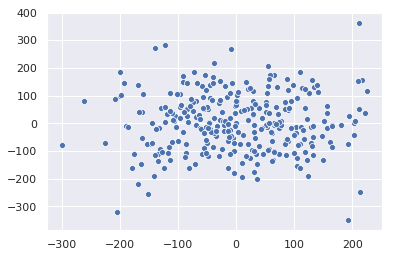

In [5]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

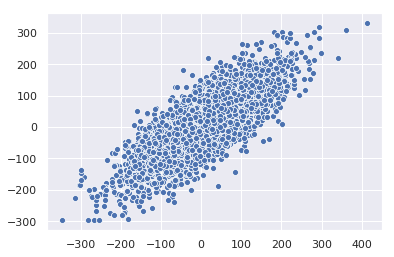

In [6]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

# Define MINE

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [8]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.relu(self.fc1(input))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [9]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.11):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    loss = -(torch.mean(t) - (et.mean()/ma_et.mean()).detach()*torch.log(torch.mean(et)))
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [10]:
def sample_batch(data, batch_size=32, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

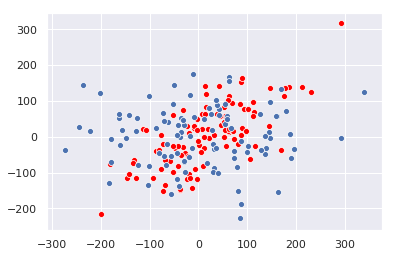

In [11]:
joint_data = sample_batch(y,batch_size=100,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0],y=joint_data[:,1],color='red')
marginal_data = sample_batch(y,batch_size=100,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,1])

In [12]:
def train(data, mine_net,mine_net_optim, batch_size=32, iter_num=int(5e+3), log_freq=1e+3):
    # data is x or y
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        ma_et = ma_et.detach()
        if (i+1)%(log_freq) == 0:
            print(mi_lb)

In [13]:
mine_net_indep = Mine()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-4)
train(x,mine_net_indep,mine_net_optim_indep)

tensor(1.00000e-02 *
       2.2842)
tensor(1.00000e-02 *
       2.7397)
tensor(1.00000e-02 *
       6.5842)
tensor(1.00000e-02 *
       2.4744)
tensor(1.00000e-02 *
       -4.6761)


In [14]:
mine_net_cor = Mine()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-4)
train(y,mine_net_cor,mine_net_optim_cor)

tensor(0.5804)
tensor(0.4679)
tensor(0.3757)
tensor(0.5548)
tensor(0.5209)
